### Packages that are useful for processing

In [24]:
import utils           #custom package to deal with 3D images 
import numpy as np

#image processing 
import skimage
from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

#image visualization 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import tifffile as tif
import ipywidgets as widgets
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.color import label2rgb

#image quantification 
import quantimpy
from quantimpy import minkowski as mk
from quantimpy import morphology as mp 

### Let's load in our data

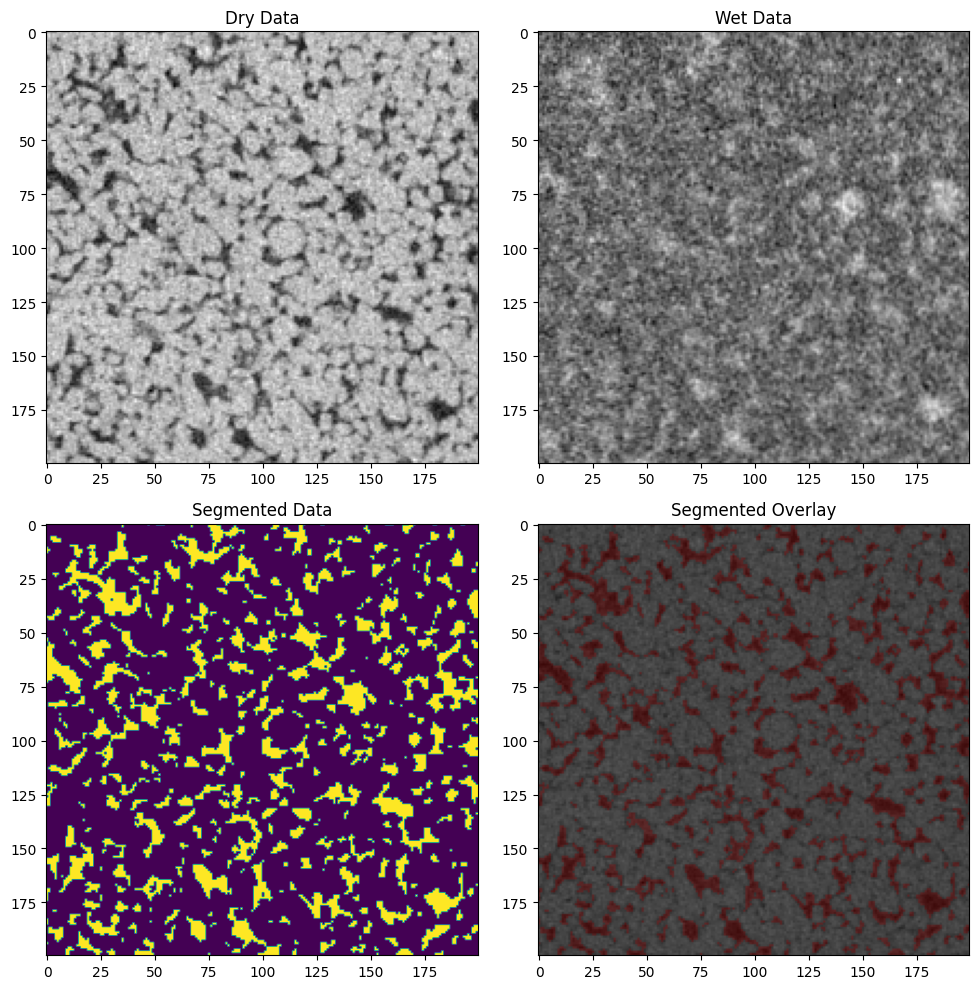

In [4]:
dry_data       = skimage.io.imread("dry_scan_subvolume.tif")
wet_data       = skimage.io.imread("wet_scan_subvolume.tif")
segmented_data = skimage.io.imread("segmented_subvolume.tif")
overlay_image  = utils.sanity_check(dry_data[20, ...], segmented_data[20, ...], 0.2)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(dry_data[20, :, :], cmap='gray')
axes[0, 0].set_title('Dry Data')
axes[0, 1].imshow(wet_data[20, :, :], cmap='gray')
axes[0, 1].set_title('Wet Data')
axes[1, 0].imshow(segmented_data[20, :, :])
axes[1, 0].set_title('Segmented Data')
axes[1, 1].imshow(overlay_image)
axes[1, 1].set_title('Segmented Overlay')
plt.tight_layout()
plt.show()

### Let's view our segmented data set in 3D 

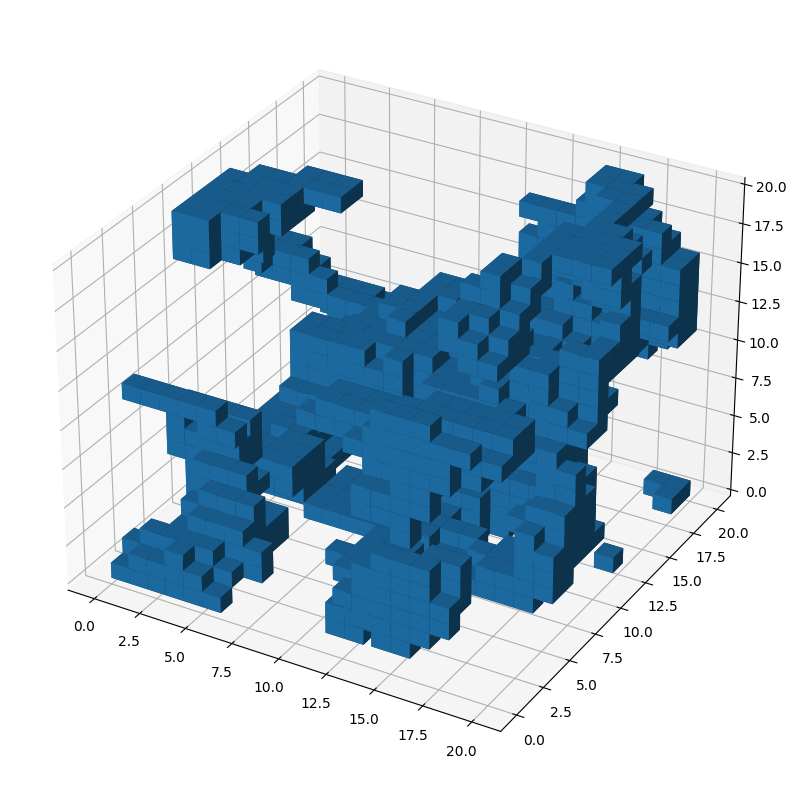

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(segmented_data[:20, :20, :20])
plt.show()

#you can see the voxels in the image. We are zooming right in to make processing quick! 

### Volume calculation

The average porosity for the subvolume is 0.2079805


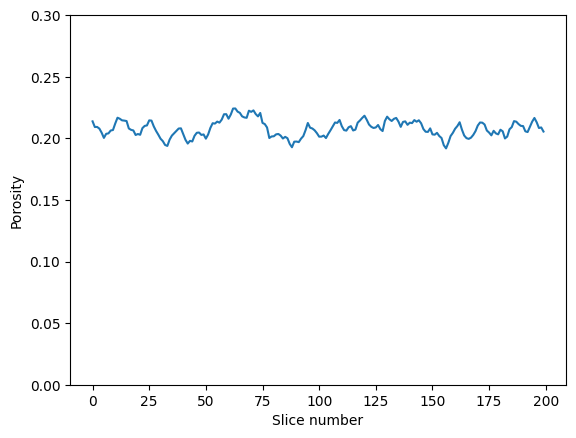

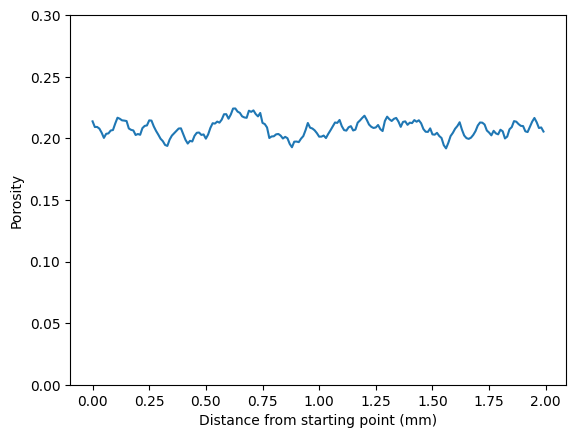

In [6]:
# volume is the easiest calculation to make. You sum up the voxels == 1 (pore = 1 and rock grains = 0) and divide by the total number of voxels 
pore_voxels = np.sum(segmented_data==1)
rock_voxels = np.sum(segmented_data==0)
porosity_total = pore_voxels / (pore_voxels + rock_voxels)
print('The average porosity for the subvolume is', porosity_total)

#but it is also useful to look at the slice averaged porosity and see how that changes 
slice_averaged_porosity    = [np.sum(image==1)/(np.sum(image==1)+np.sum(image==0))  for image in segmented_data]  #takes each z slice and works out the average porosity 
plt.plot(slice_averaged_porosity)
plt.ylabel('Porosity')
plt.xlabel('Slice number')
plt.ylim(0, 0.3)
plt.show()

#you can also convert slice number to an actual length, if you know the size of a voxel 
voxel_size = 0.01 #mm
voxel_list = [i * voxel_size for i in range(len(slice_averaged_porosity))] #these functions are called list comprehensions
plt.plot(voxel_list, slice_averaged_porosity)
plt.ylabel('Porosity')
plt.xlabel('Distance from starting point (mm)')
plt.ylim(0, 0.3)
plt.show()

### Surface area calculation

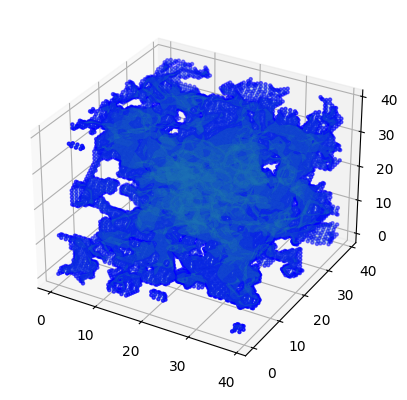

The surface area is 14033.56 voxels²


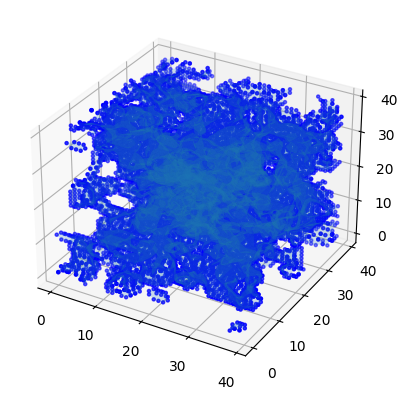

The surface area is 16261.36 voxels²
Smoothing can havilty influence the surface area calculated. In this case, the variation was 14.71 %


In [58]:
def surface_area_calculation(data, smoothing):
    #to calculate the surface area, we first need to create a surface mesh
    if smoothing == 'None':
        verts, faces, normals, values = skimage.measure.marching_cubes(data, level = None)
    else: 
        verts, faces, normals, values = skimage.measure.marching_cubes(data, level = smoothing)
    

    # Create a 3D plot to visualize the mesh 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the mesh vertices
    ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='b', marker='.')
    # Plot the mesh faces
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    ax.add_collection3d(mesh)
    plt.show()

    #from the mesh, we can calculate the surface area 
    surface_area = skimage.measure.mesh_surface_area(verts, faces)
    print('The surface area is {:.2f} voxels\u00B2'.format(surface_area))
    return surface_area

#NB, the surface area will be dependent on the smoothing chosen 
# level float, optional: Contour value to search for isosurfaces in volume. If not given or None, the average of the min and max of vol is used.
surface_area_1 = surface_area_calculation(segmented_data[:40, :40, :40], 'None')
surface_area_2 = surface_area_calculation(segmented_data[:40, :40, :40], 0)  #'blockiest' case

print('Smoothing can havilty influence the surface area calculated. In this case, the variation was {:.2f} %'.format(100*(surface_area_2- surface_area_1) / (0.5*(surface_area_2 + surface_area_1))))
      

### Mean curvature calculation 

In [72]:
# this is where things get trickier! 
# 3D curvature measurements are not trivial to calculate and there are many methods to calcualte the curvature for a 3D surface 
# we will use the module QuantImpy to help us calculate the curvature: https://doi.org/10.1016/j.softx.2021.100823

data = segmented_data[:40, :40, :40]
erosion_map = mp.erode_map(data)
dist, m0, m1, m2, m3 = mk.functions_open(erosion_map)
print(100*(np.sum(m0) - np.sum(data==1)) / (0.5*(np.sum(m0) + np.sum(data==1))))
print(np.sum(m0))
print(np.sum(data==1))

print(8* np.sum(m1))

print(np.sum(m3)*4*np.pi/3)

-0.518664047151277
12692.0
12758
13631.922812884317
-8.126849281629903
-34.04166666666666


### Euler characteristic calculation 

In [80]:
Euler = skimage.measure.euler_number(data, connectivity = 3)
print(Euler)

Euler = skimage.measure.euler_number(data, connectivity = 1)
print(Euler)

Euler = skimage.measure.euler_number(erosion_map, connectivity = 3)
print(Euler)

#A large relative difference between results for different connectivities suggests that the image resolution (with respect to the size of objects and holes) is too low.

-48
-49
-48


-48


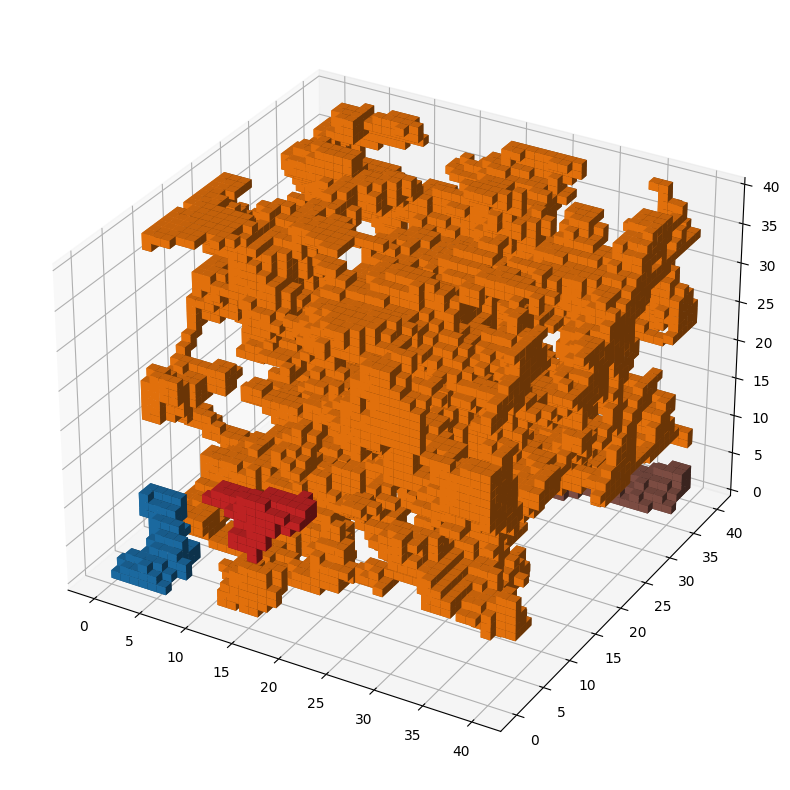

In [73]:

labeled_image = skimage.measure.label(data, connectivity =3)

num_objects   = np.max(labeled_image)


#plot the labelled image 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(1, np.max(labeled_image)): #np.max(labeled_image)
    filled_blob = skimage.morphology.remove_small_objects(labeled_image==i)
    ax.voxels(filled_blob)
    #ax.voxels(labeled_image==i)
plt.show()




### Sphere generation 

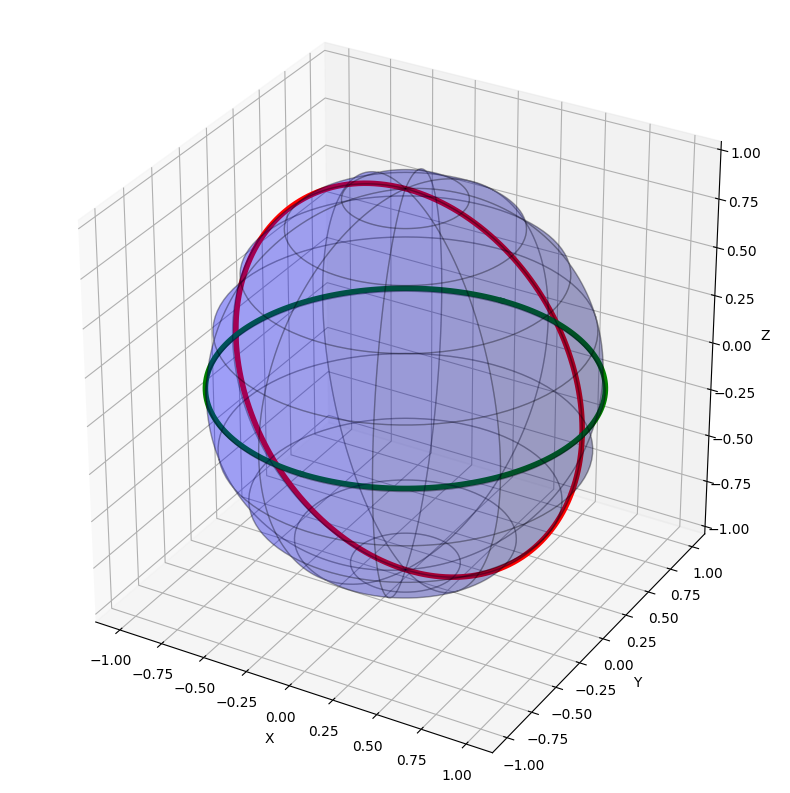

In [ ]:
# Create a 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 1.0 * np.outer(np.cos(u), np.sin(v))
y = 1.0 * np.outer(np.sin(u), np.sin(v))
z = 1.0 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the sphere
ax.plot_surface(x, y, z, color='b', alpha=0.2, rstride=10, cstride=10, zorder=0, edgecolor='k')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_box_aspect([1, 1, 1])  # [x, y, z] ratios

radius = 1.0
# Plot arcs of curvature
u_arc = np.linspace(0, np.pi , 100)  # Angle for the arc (0 to 90 degrees)
x_arc = radius * np.cos(u_arc)
y_arc = radius * np.sin(u_arc)
z_arc = np.sqrt(abs(radius**2 - x_arc**2 - y_arc**2)) 

# Plot arcs of curvature in all three dimensions
ax.plot(x_arc, z_arc, y_arc, color='r', linewidth=4, zorder=1)
ax.plot(x_arc, z_arc, -y_arc, color='r', linewidth=4, zorder=1)
ax.plot(-y_arc, x_arc, z_arc, color='g', linewidth=4, zorder=1)
ax.plot(y_arc, x_arc, z_arc, color='g', linewidth=4, zorder=1)


# Show the plot
plt.show()
